In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dgl.nn import EGATConv, EdgeWeightNorm, GraphConv
from dgl.utils import expand_as_pair
import time
torch.set_default_dtype(torch.float32)

In [2]:
from train_gpu import inference_new, train_transformer_readout
run_time = time.strftime("%Y.%m.%d-%H-%M-%S", time.localtime())
# param_search(run_time)
from config import Config
from data import part_DATA
from RC import torchRC, EGAT, EGCN
import dgl
from RC import MLP, Transformer

config = Config()
config.device = 'cuda:0'
config.data = 'mnist'
config.train_num = 50000
config.test_num = 10000
config.N_in = 28*28
config.N_hid = 100
config.N_out = 10
train_loader, test_loader = part_DATA(config)

model = torchRC(config).to(config.device)
train_rs, train_label = inference_new(model, config, train_loader,)
test_rs, test_label = inference_new(model, config, test_loader,)

Data Generation Finish
finish inference
finish inference


In [3]:
config.d_model = 64
config.encoder_layer = 2 # 增加encoder层数能略微增加性能
config.n_heads = 8 # d_model不变，增加n_head能略微增加性能，貌似比encoder_layer管用
config.d_ff = 64

config.lr = 1e-3
config.epoch = 500
config.batch_size = 50

model = Transformer(config).to(config.device)
print('model parameter:', sum(p.numel() for p in model.parameters() if p.requires_grad))


model parameter: 56896


In [48]:
X_train = train_rs[:,1:,0:config.N_hid]
y_train = train_label
X_test = test_rs[:,1:,0:config.N_hid]
y_test = test_label
train_num = X_train.shape[0]
test_num = X_test.shape[0]
iteration = int(train_num/config.batch_size)
iter = int(test_num/config.batch_size)
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

train_loss, test_loss, train_acc, test_acc = [], [], [], []
for epoch in range(config.epoch) :
    model.train()
    sum_loss = 0
    train_correct = 0
    for i in range(iteration):
        x = X_train[i*config.batch_size:(i+1)*config.batch_size] # [batch, config.frames, config.N_hid]
        y = y_train[i*config.batch_size:(i+1)*config.batch_size]
        out = model(x)

        optimizer.zero_grad()
        loss = cost(out, y)
        loss.backward()
        optimizer.step()

        _, id = torch.max(out.data, 1)
        sum_loss += loss.data
        train_correct+=torch.sum(id==y.data)
    
    model.eval()
    test_correct = 0
    for i in range(iter):
        x = X_test[i*config.batch_size:(i+1)*config.batch_size]
        y = y_test[i*config.batch_size:(i+1)*config.batch_size]
        out = model(x)
        loss = cost(out, y)
        _, id = torch.max(out.data, 1)
        test_correct += torch.sum(id == y.data)
        
    train_loss.append(sum_loss.cpu()/iteration)
    test_loss.append(loss.cpu()/iter)
    train_acc.append(train_correct.cpu()/train_num)
    test_acc.append(test_correct.cpu()/test_num)
    if config.verbose:
        print('[%d,%d] loss:%.03f, loss:%.03f, train acc:%.4f, test acc:%.4f' 
            % (epoch+1, config.epoch, sum_loss/iteration, loss.item()/iter, train_correct/train_num, test_correct/test_num))

[1,500] loss:2.827, loss:0.013, train acc:0.1003, test acc:0.1426
[2,500] loss:2.502, loss:0.013, train acc:0.1026, test acc:0.1088
[3,500] loss:2.362, loss:0.013, train acc:0.1133, test acc:0.1340
[4,500] loss:2.324, loss:0.012, train acc:0.1318, test acc:0.1512
[5,500] loss:2.341, loss:0.012, train acc:0.1278, test acc:0.1396
[6,500] loss:2.332, loss:0.012, train acc:0.1300, test acc:0.1210
[7,500] loss:2.299, loss:0.012, train acc:0.1338, test acc:0.1724
[8,500] loss:2.260, loss:0.012, train acc:0.1634, test acc:0.1880
[9,500] loss:2.278, loss:0.012, train acc:0.1771, test acc:0.1886
[10,500] loss:2.207, loss:0.011, train acc:0.2061, test acc:0.2318
[11,500] loss:2.172, loss:0.011, train acc:0.2244, test acc:0.2414
[12,500] loss:2.239, loss:0.011, train acc:0.1984, test acc:0.2530
[13,500] loss:2.192, loss:0.011, train acc:0.2203, test acc:0.2400
[14,500] loss:2.122, loss:0.011, train acc:0.2468, test acc:0.2802
[15,500] loss:2.078, loss:0.011, train acc:0.2592, test acc:0.2752
[16,

KeyboardInterrupt: 

In [5]:
train_l, test_l, train_a, test_a = train_transformer_readout(model,
                                                             config, 
                                                             train_rs[:,1:,0:config.N_hid],
                                                             test_rs[:,1:,0:config.N_hid], 
                                                             train_label, 
                                                             test_label)

[1,500] loss:2.924, loss:0.013, train acc:0.1133, test acc:0.1312


KeyboardInterrupt: 

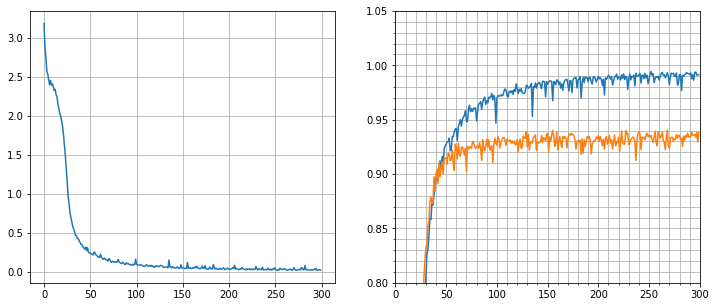

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot([l.cpu() for l in losses][0:300])
plt.grid()

plt.subplot(122)
plt.plot([a.cpu() for a in train_acc][0:300])
plt.plot([a.cpu() for a in test_acc][0:300])
plt.axis([0,300,0.8,1.05])
plt.grid(which='both')
plt.minorticks_on()

In [39]:
for i in avgpool.named_parameters():
    print(i[1].shape)

In [14]:
train_rs.shape

torch.Size([1000, 31, 2000])

In [13]:
from train_gpu import train_mlp_readout
# config.epoch = 300

# reduce frame dimension
train_rs_mlp = train_rs[:,1:,:].mean(1)
test_rs_mlp = test_rs[:,1:,:].mean(1)

mlp = MLP(2*config.N_hid, config.mlp_hid, config.N_out).to(config.device)
train_score, test_score, = train_mlp_readout(model=mlp, 
                                            config=config,
                                            X_train=train_rs_mlp,
                                            X_test=test_rs_mlp,
                                            y_train=train_label,
                                            y_test=test_label)

[1,3000] loss:0.585, train acc:0.8259, test acc:0.8945
[2,3000] loss:0.313, train acc:0.9059, test acc:0.9120
[3,3000] loss:0.265, train acc:0.9218, test acc:0.9165
[4,3000] loss:0.234, train acc:0.9307, test acc:0.9220
[5,3000] loss:0.209, train acc:0.9373, test acc:0.9260
[6,3000] loss:0.189, train acc:0.9440, test acc:0.9300
[7,3000] loss:0.173, train acc:0.9485, test acc:0.9325
[8,3000] loss:0.159, train acc:0.9531, test acc:0.9360
[9,3000] loss:0.147, train acc:0.9564, test acc:0.9395
[10,3000] loss:0.137, train acc:0.9599, test acc:0.9405
[11,3000] loss:0.127, train acc:0.9628, test acc:0.9430
[12,3000] loss:0.118, train acc:0.9659, test acc:0.9405
[13,3000] loss:0.111, train acc:0.9679, test acc:0.9420
[14,3000] loss:0.103, train acc:0.9699, test acc:0.9400
[15,3000] loss:0.097, train acc:0.9724, test acc:0.9400
[16,3000] loss:0.091, train acc:0.9744, test acc:0.9385
[17,3000] loss:0.086, train acc:0.9765, test acc:0.9370
[18,3000] loss:0.081, train acc:0.9780, test acc:0.9355
[

KeyboardInterrupt: 

In [61]:
v = train_rs[index][:,1:,0:config.N_hid]
# v = v.transpose(1,2).view(-1,30)
# node_feat = Egcn(g, v[0:config.N_hid], edge_attr)

In [76]:
train_label[index].view(1,-1)[0]

tensor([0, 3, 4, 7, 0])

In [69]:
v.shape

torch.Size([5, 30, 200])

In [70]:
batch_v = v.transpose(1,2).reshape(-1, 30)
batch_g = dgl.batch([g]*5)
batch_edge_attr = torch.cat(([edge_attr]*5))

In [71]:
node_feat = Egcn(batch_g, batch_v, batch_edge_attr)
# pred = node_feat.argmax(1)

In [73]:
batch_label

NameError: name 'batch_label' is not defined

In [65]:
pred

tensor([5, 8, 5, 5, 9, 9, 9, 8, 8, 9])

In [20]:
for i in transformer_encoder.named_parameters():
    print(i[1].shape)

torch.Size([1536, 512])
torch.Size([1536])
torch.Size([512, 512])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1536, 512])
torch.Size([1536])
torch.Size([512, 512])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1536, 512])
torch.Size([1536])
torch.Size([512, 512])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1536, 512])
torch.Size([1536])
torch.Size([512, 512])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1536, 512])
torch.Size([

In [78]:
64*30+64+64*32*32+310+330

68160

In [18]:
batch_f.shape

torch.Size([12, 30])

In [22]:
u = [0,1,2,3,2,5]
v = [1,2,3,4,0,3]
g = dgl.graph((u,v))
g = dgl.add_self_loop(g)

batch_g = dgl.batch([g, g])
feat = torch.ones(6, 3)
batch_f = torch.cat([feat, feat])

edge_weight = torch.tensor([0.5, 0.6, 0.4, 0.7, 0.9, 0.1, 1, 1, 1, 1, 1, 1])
norm = EdgeWeightNorm(norm='both')
norm_edge_weight = norm(g, edge_weight)
conv1 = GraphConv(3, 2, norm='none', weight=True, bias=True, activation=None)
conv2 = GraphConv(3, 2, norm='none', weight=True, bias=True, activation=nn.Softmax())
conv2.weight = conv1.weight
conv2.bias = conv1.bias

# out1 = conv(batch_g, batch_f, edge_weight=norm_edge_weight)
out2 = conv1(batch_g, batch_f, edge_weight=None)
out3 = conv2(batch_g, batch_f, edge_weight=None)
# out3 = conv(g, feat, edge_weight=edge_weight)
# print(out1,'\n', out2, '\n', out3)

c:\ProgramData\Anaconda3\envs\snn\lib\site-packages\dgl\nn\pytorch\conv\graphconv.py:447: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rst = self._activation(rst)


In [23]:
out2,out3

(tensor([[-3.1475,  0.8163],
         [-3.1475,  0.8163],
         [-3.1475,  0.8163],
         [-4.7213,  1.2245],
         [-3.1475,  0.8163],
         [-1.5738,  0.4082],
         [-3.1475,  0.8163],
         [-3.1475,  0.8163],
         [-3.1475,  0.8163],
         [-4.7213,  1.2245],
         [-3.1475,  0.8163],
         [-1.5738,  0.4082]], grad_fn=<AddBackward0>),
 tensor([[0.0186, 0.9814],
         [0.0186, 0.9814],
         [0.0186, 0.9814],
         [0.0026, 0.9974],
         [0.0186, 0.9814],
         [0.1211, 0.8789],
         [0.0186, 0.9814],
         [0.0186, 0.9814],
         [0.0186, 0.9814],
         [0.0026, 0.9974],
         [0.0186, 0.9814],
         [0.1211, 0.8789]], grad_fn=<SoftmaxBackward0>))

In [23]:
a = graph.adjacency_matrix()

TypeError: can't convert Sparse layout tensor to numpy.convert the tensor to a strided layout first.

In [24]:
num_nodes, num_edges = 8, 30
node_dim = 20
edge_dim = 1
graph = dgl.rand_graph(num_nodes, num_edges)
node_feats = torch.rand((num_nodes, node_dim))
edge_feats = torch.rand((num_edges, edge_dim))
egat = EGATConv(in_node_feats=node_dim,
                in_edge_feats=edge_dim,
                out_node_feats=15,
                out_edge_feats=1,
                num_heads=3)
#forward pass
new_node_feats, new_edge_feats = egat(graph, node_feats, edge_feats)
new_node_feats.shape, new_edge_feats.shape

(torch.Size([8, 3, 15]), torch.Size([30, 3, 1]))

In [28]:
new_edge_feats[0]

tensor([[1.7398],
        [2.1219],
        [0.2601]], grad_fn=<SelectBackward0>)

In [29]:
new_edge_feats.mean(1)[0]

tensor([1.3739], grad_fn=<SelectBackward0>)

In [47]:
import dgl.data

dataset = dgl.data.CoraGraphDataset('./data')
print('Number of categories:', dataset.num_classes)
g = dataset[0]
print(g.ndata)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7
{'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}


In [43]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [13]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(30):
        logits = model(g, features)
        pred = logits.argmax(1)
        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

NameError: name 'GCN' is not defined

In [7]:
from config import Config as config
from RC import torchRC
model = torchRC(config)
mem, spike = model(torch.rand(16, config.frames, 50))
print(mem.shape)

torch.Size([1, 16, 101, 200])


In [45]:
A = model.reservoir.A.numpy()
edge_index = torch.tensor(np.where(A!=0), dtype=torch.long)
edge_attr = torch.tensor(np.array([A[i,j] for i,j in edge_index.T]))
u = edge_index[0]
v = edge_index[1]
mems = mem[0,0,1:].T
g = dgl.graph((u, v))
g.ndata['x'] = mems
g.edata['w'] = edge_attr

h = dgl.graph((u, v))
h.ndata['x'] = mems

In [40]:
g = dgl.graph((u, v))
g.ndata['x'] = mems
g.edata['w'] = edge_attr

h = dgl.graph((u, v))
h.ndata['x'] = mems

In [37]:
from dgl.nn import GraphConv
conv1 = GraphConv(config.frames, 16)
out = conv1(g, mems)
out_h = conv1(h, mems)
print(out_h[0])
print(out[0])

In [47]:
edge_attr

tensor([ 0.3371, -0.0486,  0.0422,  ...,  0.0489, -0.0459,  0.3718])

In [46]:
from torch_geometric.nn import GCNConv
conv2 = GCNConv(100, 16)
conv2(mems, edge_index, edge_attr)

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<AddBackward0>)